In [1]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

In [2]:
model_type = "DPT_Hybrid"
midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /Users/deniskrylov/.cache/torch/hub/intel-isl_MiDaS_master
/Users/deniskrylov/Developer/PosEmotion/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/deniskrylov/Developer/PosEmotion/.venv/lib/python3.12/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): HybridEmbed(
        (backbone): ResNetV2(
          (stem): Sequential(
            (conv): StdConv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
            (norm): GroupNormAct(
              32, 64, eps=1e-05, affine=True
              (drop): Identity()
              (act): ReLU(inplace=True)
            )
            (pool): MaxPool2dSame(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
          )
          (stages): Sequential(
            (0): ResNetStage(
              (blocks): Sequential(
                (0): Bottleneck(
                  (downsample): DownsampleConv(
                    (conv): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                    (norm): GroupNormAct(
                      32, 256, eps=1e-05, affine=True
                      (drop): Identity()
                      (act): Identit

In [4]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /Users/deniskrylov/.cache/torch/hub/intel-isl_MiDaS_master


In [5]:
img = cv2.imread("assets/frames/Bqb2wT_eP_4_262.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

In [6]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

[1113.7722  1114.9814  1116.9402  ...  396.2457   340.04813  303.77283]


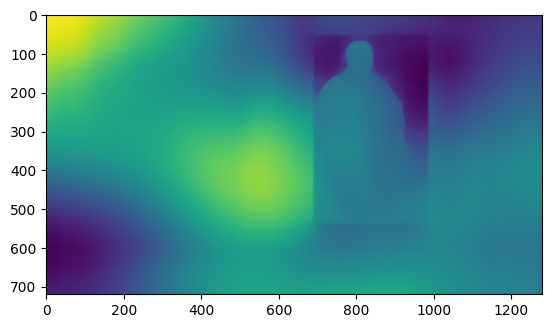

In [7]:
print(output[0])
plt.imshow(output)

In [8]:
# get depth of a pixel with coordinates (x,y) from output
x1, y1 = 929, 346
x2, y2 = 682, 344

depth1 = output[y1, x1]
print(depth1)

depth2 = output[y2, x2]
print(depth2)

567.52124
829.5107


In [9]:




# Load the pre-trained MoveNet model from TensorFlow Hub
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")

NameError: name 'hub' is not defined

[[0.24789850413799286, 0.5749025344848633, 0.698839008808136], [0.212553009390831, 0.6056094169616699, 0.5632132291793823], [0.2133622169494629, 0.5547958612442017, 0.7766785621643066], [0.23667719960212708, 0.6587850451469421, 0.6991982460021973], [0.23020416498184204, 0.551983118057251, 0.581174373626709], [0.4308173358440399, 0.6864673495292664, 0.758993923664093], [0.41133296489715576, 0.53814297914505, 0.5422630906105042], [0.793825626373291, 0.7386943101882935, 0.5807501077651978], [0.6227794289588928, 0.5485525727272034, 0.3486296832561493], [0.7686938643455505, 0.6087188720703125, 0.6424172520637512], [0.7213394641876221, 0.5231611728668213, 0.2677156329154968], [0.8419259786605835, 0.6567607522010803, 0.46923041343688965], [0.8202123045921326, 0.5585051774978638, 0.38561582565307617], [0.9843925833702087, 0.6180685758590698, 0.18522539734840393], [0.9854480028152466, 0.5305519104003906, 0.14125047624111176], [0.9976088404655457, 0.6193509101867676, 0.048178333789110184], [1.00

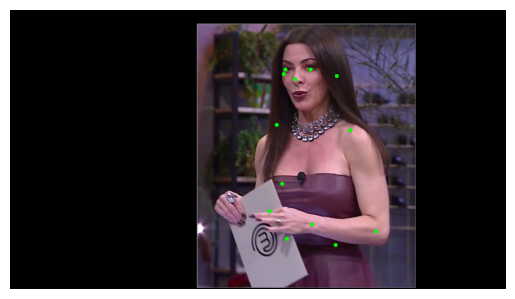

In [ ]:


def run_inference(model, image):
    # Resize and normalize the image
    input_image = tf.image.resize(image, (192, 192))
    input_image = tf.expand_dims(input_image, axis=0)
    input_image = tf.cast(input_image, dtype=tf.int32)

    # Run inference
    outputs = model.signatures["serving_default"](input_image)
    keypoints = outputs['output_0'].numpy()

    return keypoints

# Load the image
image_path = 'assets/frames/aJKL0ahn1Dk_10.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run pose estimation
keypoints = run_inference(model, image_rgb)
print(keypoints[0][0].tolist())

# Get the original image dimensions
original_height, original_width, _ = image.shape

# Iterate through the keypoints and scale them to match the original image size
for keypoint in keypoints[0][0]:
    y, x, confidence = keypoint
    # Scale keypoints to match the original image size
    y *= original_height
    x *= original_width
    if confidence > 0.2:  # Draw keypoint if confidence is above threshold
        cv2.circle(image_rgb, (int(x), int(y)), 5, (0, 255, 0), -1)
    print(x, y)

# Display the image with detected poses
plt.imshow(image_rgb)
plt.axis('off')
plt.show()